In [1]:
import FPL_data
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

Use our custom function to load the data from disk

In [2]:
week_number, plyr_df, team_df, next_game_df, history_df = FPL_data.load_FPL_data(28)

In [3]:
history_df.columns

Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'kickoff_time', 'kickoff_time_formatted', 'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'round', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
       'total_points', 'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards', 'player_id'],
      dtype='object')

In [4]:
history_df[history_df['player_id']==443]

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,player_id
16709,0,10,0,0,0,3,0,0,9,0.6,...,18.0,0,0,0,0,50,False,0,0,443
16710,0,21,0,0,0,16,0,6,17,52.9,...,0.0,1,-1515,945,2460,50,False,0,0,443
16711,0,43,0,0,0,11,0,4,36,1.6,...,11.0,1,-269,2323,2592,50,False,0,0,443
16712,0,22,1,0,0,23,1,3,14,47.1,...,1.0,6,-338,2793,3131,50,True,0,0,443
16713,0,30,0,0,3,30,1,4,27,34.3,...,0.0,9,905,3136,2231,50,False,0,0,443
16714,0,44,0,0,0,5,0,0,30,14.3,...,2.0,1,3309,6037,2728,50,True,0,0,443
16715,0,40,0,0,0,27,1,4,30,33.8,...,0.0,6,22776,26720,3944,50,True,0,0,443
16716,0,25,0,0,0,8,0,3,16,1.3,...,0.0,2,1364,7453,6089,50,False,0,0,443
16717,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0,7986,10652,2666,50,True,0,0,443
16718,1,17,1,0,0,15,0,3,13,11.2,...,2.0,4,-9169,1213,10382,50,False,0,0,443


Define a funcion to transform & merge the different data sources for input to the model

In [36]:
def data_prep(current_gameweek, hist_df):
    # Function to create input features and target labels for a given gameweek
    
    # Features should all come from before the gameweek we're predicting
    X = hist_df[hist_df['round']==current_gameweek]
    
    # The target variable is the points scored in the gameweek
    next_week_points = hist_df[hist_df['round']==current_gameweek+1]
    next_week_points = next_week_points.loc[:,('total_points','player_id')]
    X = X.merge(next_week_points,left_on='player_id',right_on='player_id',how='left',suffixes=['','_next_week'])

    # Replace missing points values with zero
    X['total_points'].fillna(0)
    X['total_points_next_week'].fillna(0)
    
    
    # Should drop player id and some others as it doesn't mean anything
    # Also, create features from previous weeks too
    
    
    # For now, drop non-numeric columns
    X = X._get_numeric_data()
    
    return X

In [37]:
X = data_prep(1,history_df)

In [38]:
X[['player_id','total_points','total_points_next_week']]

,player_id,total_points,total_points_next_week
0,1,0,0
1,1,0,0
2,2,1,3
3,2,1,3
4,3,0,0
5,3,0,0
6,4,0,0
7,4,0,0
8,5,0,0
9,5,0,0


In [39]:
X['round'].value_counts()

1    709
Name: round, dtype: int64

In [40]:
y = X.pop('total_points_next_week')

In [41]:
y.isnull().any()

False

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [43]:
X.columns

Index(['assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'element', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fixture', 'fouls', 'goals_conceded',
       'goals_scored', 'ict_index', 'id', 'influence', 'key_passes',
       'loaned_in', 'loaned_out', 'minutes', 'offside', 'open_play_crosses',
       'opponent_team', 'own_goals', 'penalties_conceded', 'penalties_missed',
       'penalties_saved', 'recoveries', 'red_cards', 'round', 'saves',
       'selected', 'tackled', 'tackles', 'target_missed', 'team_a_score',
       'team_h_score', 'threat', 'total_points', 'transfers_balance',
       'transfers_in', 'transfers_out', 'value', 'was_home', 'winning_goals',
       'yellow_cards', 'player_id'],
      dtype='object')

In [44]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train,y_train)
y_predict = tree_model.predict(X_test)

First, let's get a baseline by putting in the average

In [45]:
print('Mean squared error: {0}'.format(mean_squared_error(y_test, np.repeat(np.average(y_train), len(y_test)))))

Mean squared error: 6.313208305514123


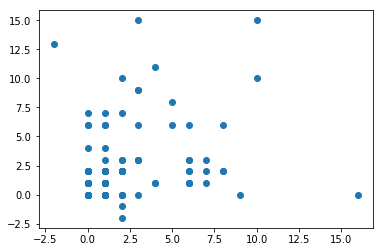

In [46]:
plt.scatter(y_predict, y_test)

In [47]:
print('Mean squared error: {0}'.format(mean_squared_error(y_test, y_predict)))

Mean squared error: 6.837606837606837


This is bad, we would have been better to use the average! And we have an advantage as we've split a single gameweek for training and testing, so players in the same team will have the same opposition team. If we test this model on the next gameweek performance will likely be worse.

However, we haven't made use of a lot of useful data, and we can eventually train over many weeks, so there is room for improvement!

Out of interest let's see how bad the results are when using this simple model for the next gameweek.

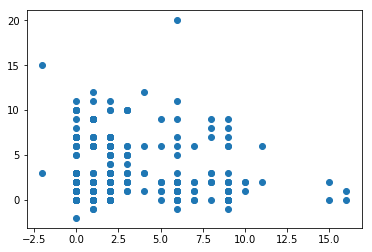

In [48]:
# Use trained model on data from gameweek 4 to predict gameweek 5's scores
X = data_prep(4, history_df)
y = X.pop('total_points_next_week')
y_predict = tree_model.predict(X)

plt.scatter(y_predict, y)

In [49]:
print('Mean squared error: {0}'.format(mean_squared_error(y,y_predict)))

Mean squared error: 14.871967654986523


In [50]:
print('Mean squared error: {0}'.format(mean_squared_error(y, np.repeat(np.average(X['total_points']), len(y)))))

Mean squared error: 7.264828430482198


Again, we would have been better to just use the average score from the previous week for all players.


Let's predict for the current week

In [51]:
X = data_prep(27, history_df)
y = X.pop('total_points_next_week')
y_predict = tree_model.predict(X)
y_predict

array([ 0.,  6.,  0.,  6.,  0.,  0.,  0.,  0.,  6.,  0.,  6.,  9., -2.,
        0.,  9.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.,  9.,  9.,  4.,  5.,  2.,  1.,
        0.,  9.,  2.,  0.,  0.,  9.,  1.,  5.,  0.,  3.,  0.,  2.,  5.,
        0.,  3.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
        0.,  9.,  9.,  2.,  9.,  9.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  6.,  0.,  6.,  0.,  0.,  0.,  0.,  6.,  0.,  6.,  9., -2.,
        0.,  9.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  2.,  9.,  9.,  4.,  5.,  2.,  1.,
        0.,  9.,  2.,  0.,  0.,  9.,  1.,  5.,  0.,  3.,  0.,  2.,  5.,
        0.,  3.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,
        0.,  9.,  9.,  2.,  9.,  9.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  2.,  6.,  9.,  0.,  0.,  0.,  0.,  5.,  1.,  6.,  0.,  0.,
        0.,  9.,  0.,  0.,  1.,  9.,  9.,  0.,  2.,  0.,  0.,  2

In [52]:
def merge_preds_and_players(X,y,plyr_df):
    ids = X['player_id']
    names = plyr_df[['id','web_name']]
    
    preds_df = pd.DataFrame(data={'player_id':ids, 'predicted_score':y})
    
    preds_df = preds_df.merge(names, left_on='player_id', right_on='id', how='left')
    preds_df = preds_df.drop('id', axis=1)
    
    return preds_df

In [53]:
results = merge_preds_and_players(X,y_predict, plyr_df)
results.to_csv("Gameweek 28 predictions.csv")
results

,player_id,predicted_score,web_name
0,1,0.0,Ospina
1,2,6.0,Cech
2,3,0.0,Martinez
3,4,6.0,Koscielny
4,5,0.0,Mertesacker
5,6,0.0,Gabriel
6,7,0.0,Bellerín
7,9,0.0,Jenkinson
8,10,6.0,Monreal
9,11,0.0,Holding


In [54]:
results.sort_values(by='predicted_score', ascending=False)

,player_id,predicted_score,web_name
650,432,16.0,Phillips
574,382,16.0,Trippier
611,409,15.0,Capoue
248,131,11.0,Townsend
606,404,10.0,Janmaat
616,414,10.0,Doucouré
231,108,9.0,Loftus-Cheek
159,72,9.0,Hemed
404,259,9.0,Jesus
401,255,9.0,Sané


In [55]:
feature_importances = pd.DataFrame(data={'Feature':X.columns,'Importance':tree_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
feature_importances

,Feature,Importance
25,minutes,0.245414
28,opponent_team,0.159931
8,completed_passes,0.126013
52,player_id,0.062263
5,bps,0.061409
37,selected,0.050612
9,creativity,0.040204
20,id,0.036990
1,attempted_passes,0.033548
43,threat,0.032827


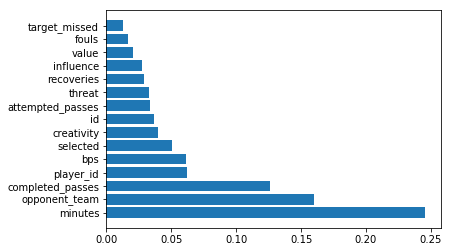

In [56]:
threshold = 0.01
y = range(feature_importances[feature_importances['Importance']>threshold].shape[0])
plt.barh(y,feature_importances[feature_importances['Importance']>threshold].Importance)
plt.yticks(y,feature_importances['Feature'])
plt.show()

In [57]:
history_df[['element','id']]

,element,id
0,1,1
1,1,512
2,1,1028
3,1,1559
4,1,2103
5,1,2649
6,1,3199
7,1,3753
8,1,4310
9,1,4869


Let's try predicting gameweek 5 again, but training on data from weeks 1-3, then using 4 to predict

In [58]:
X = data_prep(1,history_df)
for i in (2,3):
    print(X.shape[0])
    X = X.append(data_prep(i,history_df))

709
1423


In [59]:
X['round'].value_counts()

3    729
2    714
1    709
Name: round, dtype: int64

In [60]:
y = X.pop('total_points_next_week')
tree_model.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [61]:
X = data_prep(4,history_df)
y = X.pop('total_points_next_week')
y_predict = tree_model.predict(X)
print('Mean squared error: {0}'.format(mean_squared_error(y,y_predict)))

Mean squared error: 11.95687331536388


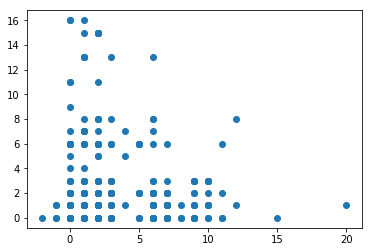

In [62]:
plt.scatter(y,y_predict);

In [63]:
results = merge_preds_and_players(X,y_predict, plyr_df)

In [67]:
results[results['predicted_score']==16]

,player_id,predicted_score,web_name
438,19,16.0,Chamberlain
442,216,16.0,Moreno
455,230,16.0,Mané


In [65]:
def plot_feature_importance(X, model, threshold=0.01):
    feature_importances = pd.DataFrame(data={'Feature':X.columns,'Importance':model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance')
    y = range(feature_importances[feature_importances['Importance']>threshold].shape[0])
    plt.barh(y,feature_importances[feature_importances['Importance']>threshold].Importance)
    plt.yticks(y,feature_importances['Feature'])
    plt.show()

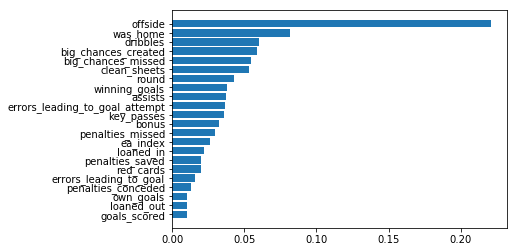

In [66]:
plot_feature_importance(X,tree_model)

,assists,attempted_passes,big_chances_created,big_chances_missed,bonus,bps,clean_sheets,clearances_blocks_interceptions,completed_passes,creativity,...,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,winning_goals,yellow_cards,player_id
0,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0,-730,155,885,49,True,0,0,1
1,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0,-730,155,885,49,True,0,0,1
2,0,32,0,0,0,25,1,0,16,0.0,...,0.0,6,-14720,5428,20148,55,True,0,0,2
3,0,32,0,0,0,25,1,0,16,0.0,...,0.0,6,-14720,5428,20148,55,True,0,0,2
4,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0,-2948,103,3051,40,True,0,0,3
